In [ ]:
# importing modules
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import tree
import pickle
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Loading the data
deadline_df = pd.read_csv('deadlines.csv', sep=";")

Data Exploration

In [ ]:
deadline_df.head(3)

,id,task_id,title,workflow_id,workflow_title,action_id,action_title,from_status_id,from_status_title,to_status_id,to_status_title,deadline_set_by,deadline_set_by_title,deadline_set_on,deadline_set_on_title,deadline_set_at,deadline,deadline_closed_at,number_of_files
0,2682,14,Քաղաքացի Արմեն Արարատյանի դիմումը /հասցե` ԵՐԵՎ...,5,Դիմումներ քաղաքացիներից,65,Ի կատարումն,32,Սպասում է մակագրության,38,Մակագրված է ի կատարում,3,Երևանի քաղաքապետ,184,Երևանի քաղաքապետարանի աշխատակազմի բնապահպանութ...,2022-04-01 19:15:42.995975,2022-04-08 18:00:00,2022-04-13 16:41:59.366937,0
1,3509,14,Քաղաքացի Արմեն Արարատյանի դիմումը /հասցե` ԵՐԵՎ...,5,Դիմումներ քաղաքացիներից,65,Ի կատարումն,38,Մակագրված է ի կատարում,38,Մակագրված է ի կատարում,184,Երևանի քաղաքապետարանի աշխատակազմի բնապահպանութ...,190,Երևանի քաղաքապետարանի աշխատակազմի բնապահպանութ...,2022-04-04 14:06:41.225952,2022-04-08 18:00:00,2022-04-06 16:39:49.957361,0
2,3963,14,Քաղաքացի Արմեն Արարատյանի դիմումը /հասցե` ԵՐԵՎ...,5,Դիմումներ քաղաքացիներից,72,Նշանակել կատարող,38,Մակագրված է ի կատարում,30,Նշանակվել է կատարող,190,Երևանի քաղաքապետարանի աշխատակազմի բնապահպանութ...,817,Կանաչապատում և շրջակա միջավայրի պահպանություն ...,2022-04-04 16:14:05.643992,2022-04-08 18:00:00,2022-04-04 16:15:51.72471,0


In [ ]:
deadline_df.shape

(10000, 19)

In [ ]:
deadline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     10000 non-null  int64 
 1   task_id                10000 non-null  int64 
 2   title                  10000 non-null  object
 3   workflow_id            10000 non-null  int64 
 4   workflow_title         10000 non-null  object
 5   action_id              10000 non-null  int64 
 6   action_title           10000 non-null  object
 7   from_status_id         10000 non-null  int64 
 8   from_status_title      10000 non-null  object
 9   to_status_id           10000 non-null  int64 
 10  to_status_title        10000 non-null  object
 11  deadline_set_by        10000 non-null  int64 
 12  deadline_set_by_title  10000 non-null  object
 13  deadline_set_on        10000 non-null  int64 
 14  deadline_set_on_title  10000 non-null  object
 15  deadline_set_at     

In [ ]:
# Getting a copy of our dataset to keep the original unchanged
df = deadline_df.copy()

In [ ]:
# Converting deadline information, which belong to 'object' data type into 'datetime'
df['deadline_closed_at'] = pd.to_datetime(df['deadline_closed_at'])
df['deadline_set_at'] = pd.to_datetime(df['deadline_set_at'])
df['deadline'] = pd.to_datetime(df['deadline'])

In [ ]:
# Calculating the task duration and planned task duration
df['actual task duration'] = df['deadline_closed_at'] - df['deadline_set_at']
df['planned task duration'] = df['deadline'] - df['deadline_set_at']

In [ ]:
# Converting deadline times into minutes
df['actual task duration in minutes'] = df['actual task duration']/np.timedelta64(1, 'm')
df['planned task duration in minutes'] = df['planned task duration']/np.timedelta64(1, 'm')

In [ ]:
df.describe()

,id,task_id,workflow_id,action_id,from_status_id,to_status_id,deadline_set_by,deadline_set_on,number_of_files,actual task duration,planned task duration,actual task duration in minutes,planned task duration in minutes
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.0,9842,10000,9842.000000,10000.000000
mean,16662.804200,5043.531600,9.893600,182.070500,95.106400,94.505200,607.302500,652.48400,0.0,12 days 20:22:04.048337730,10 days 20:24:19.697872832,18502.067472,15624.328298
std,29813.649062,3293.975127,7.270018,183.175159,90.631171,89.411267,546.514881,483.40303,0.0,28 days 12:34:26.681690100,9 days 18:59:49.504777171,41074.444695,14099.825080
min,2478.000000,14.000000,4.000000,28.000000,13.000000,13.000000,2.000000,2.00000,0.0,0 days 00:00:04.750220,0 days 00:03:20.472001,0.079170,3.341200
25%,7333.750000,2137.000000,5.000000,65.000000,32.000000,30.000000,79.000000,291.00000,0.0,1 days 22:44:45.500682250,4 days 00:21:23.554000500,2804.758345,5781.392567
50%,11551.500000,4719.000000,5.000000,72.000000,38.000000,38.000000,545.000000,545.00000,0.0,6 days 03:41:01.560931500,7 days 14:47:50.651779,8861.026016,10967.844196
75%,15973.750000,7719.250000,20.000000,417.000000,215.000000,221.000000,961.000000,866.00000,0.0,13 days 06:16:35.916053,14 days 05:23:38.304996500,19096.598601,20483.638417
max,666524.000000,11208.000000,26.000000,902.000000,423.000000,343.000000,1735.000000,1982.00000,0.0,341 days 18:26:18.688256,235 days 15:06:58.232345,492146.311471,339306.970539


Data Visualisation

In [ ]:
v1 = df['workflow_id']
v2 = df['action_id']
v3 = df['from_status_id']
v4 = df['to_status_id']
v5 = df['deadline_set_by']
v6 = df['deadline_set_on']
w1 = df['actual task duration in minutes']
w2 = df['planned task duration in minutes']

[Text(0.5, 1.0, 'Frequency Histogram'), Text(0, 0.5, 'Frequency')]

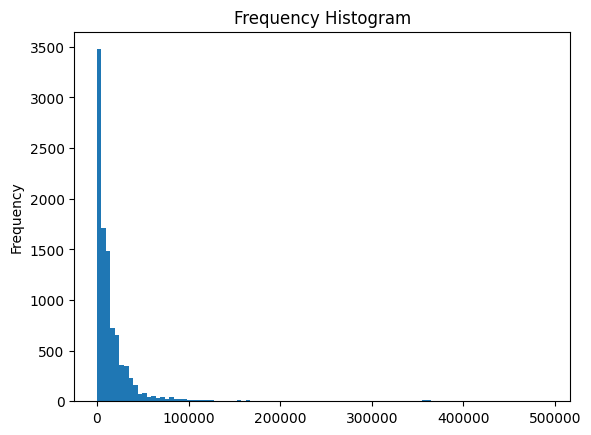

In [ ]:
plt.hist(w1, bins=100)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency')

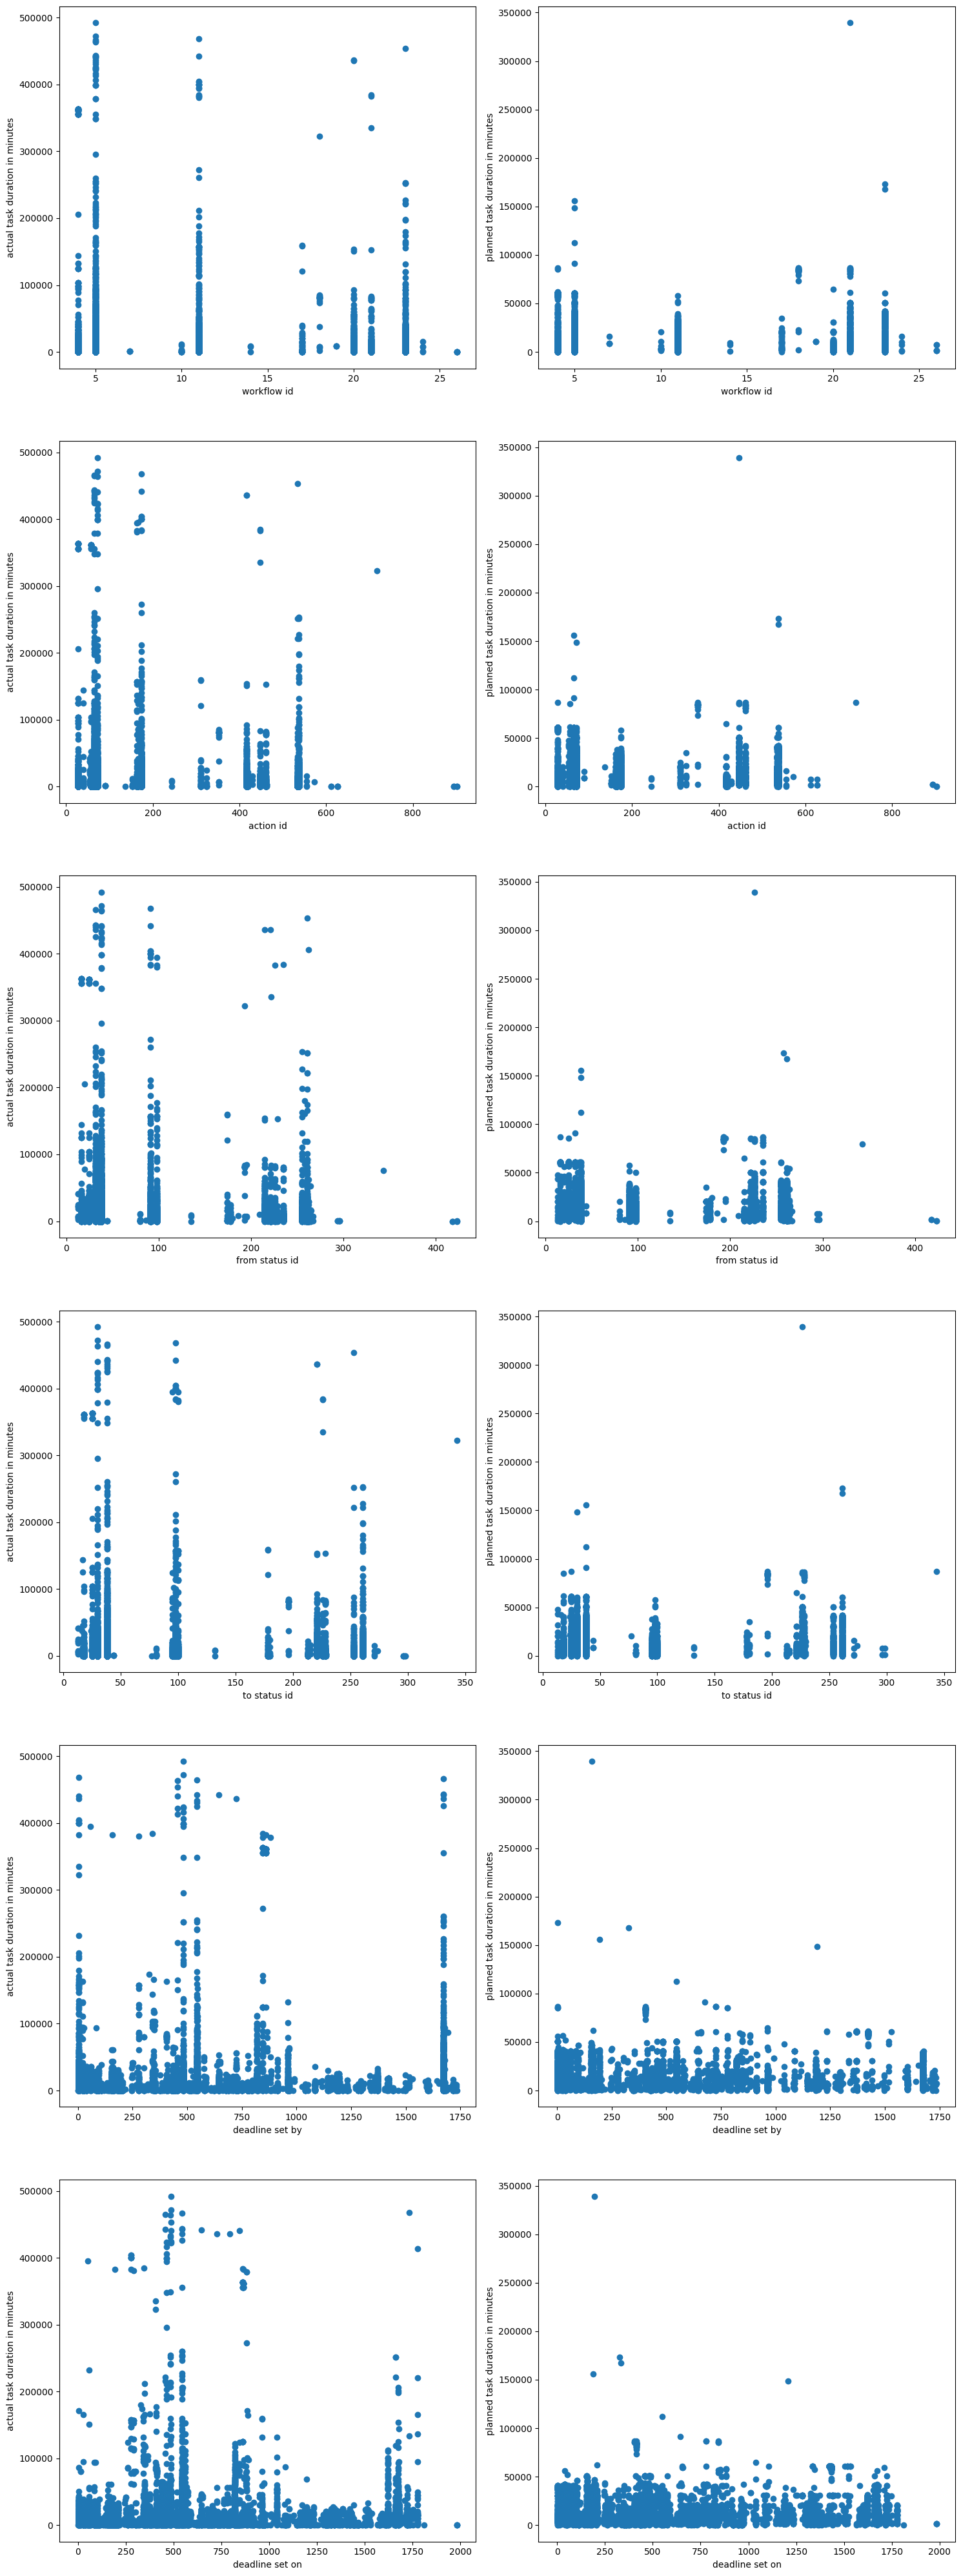

In [ ]:
# How task durations change, when id values change
fig, axs = plt.subplots(6, 2, figsize=(15,40))

axs[0, 0].scatter(v1, w1)
axs[0, 0].set_xlabel('workflow id')
axs[0, 0].set_ylabel('actual task duration in minutes')

axs[0, 1].scatter(v1, w2)
axs[0, 1].set_xlabel('workflow id')
axs[0, 1].set_ylabel('planned task duration in minutes')

axs[1, 0].scatter(v2, w1)
axs[1, 0].set_xlabel('action id')
axs[1, 0].set_ylabel('actual task duration in minutes')

axs[1, 1].scatter(v2, w2)
axs[1, 1].set_xlabel('action id')
axs[1, 1].set_ylabel('planned task duration in minutes')

axs[2, 0].scatter(v3, w1)
axs[2, 0].set_xlabel('from status id')
axs[2, 0].set_ylabel('actual task duration in minutes')

axs[2, 1].scatter(v3, w2)
axs[2, 1].set_xlabel('from status id')
axs[2, 1].set_ylabel('planned task duration in minutes')

axs[3, 0].scatter(v4, w1)
axs[3, 0].set_xlabel('to status id')
axs[3, 0].set_ylabel('actual task duration in minutes')

axs[3, 1].scatter(v4, w2)
axs[3, 1].set_xlabel('to status id')
axs[3, 1].set_ylabel('planned task duration in minutes')

axs[4, 0].scatter(v5, w1)
axs[4, 0].set_xlabel('deadline set by')
axs[4, 0].set_ylabel('actual task duration in minutes')

axs[4, 1].scatter(v5, w2)
axs[4, 1].set_xlabel('deadline set by')
axs[4, 1].set_ylabel('planned task duration in minutes')

axs[5, 0].scatter(v6, w1)
axs[5, 0].set_xlabel('deadline set on')
axs[5, 0].set_ylabel('actual task duration in minutes')

axs[5, 1].scatter(v6, w2)
axs[5, 1].set_xlabel('deadline set on')
axs[5, 1].set_ylabel('planned task duration in minutes')

fig.tight_layout(h_pad=5)
plt.show()

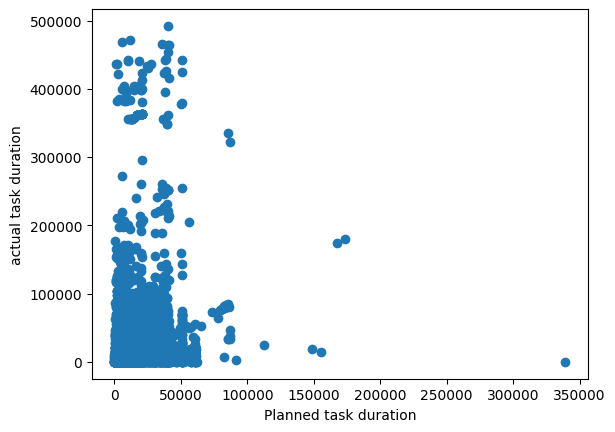

In [ ]:
# How actual task durations change, when planned task durations change
plt.scatter(w2, w1)
plt.xlabel('Planned task duration')
plt.ylabel('actual task duration')
plt.show()

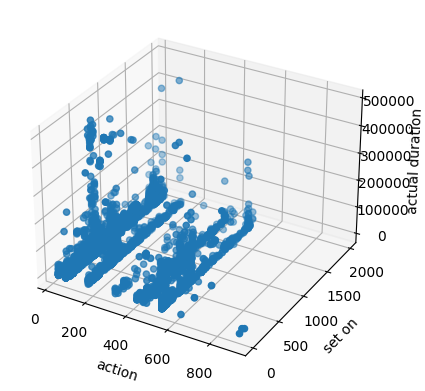

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(v2, v6, w1)
ax.set_xlabel('action')
ax.set_ylabel('set on')
ax.set_zlabel('actual duration')
plt.show()

Data Preparation

In [ ]:
# Dropping nan values
df2 = df.dropna().reset_index(drop=True)

In [ ]:
# How many times ppl completed tasks before the set deadline
d = []
for j in range(df2.shape[0]):
    if df2['planned task duration in minutes'][j] > df2['actual task duration in minutes'][j]:
       d.append(j)
print(len(d)/df.shape[0]*100, '%')

68.53281853281852 %


In [ ]:
# Calculating root mean squared error of deadlines set by humans in raw data
e1 = df2['actual task duration in minutes']
e2 = df2['planned task duration in minutes']
error = mean_squared_error(e1, e2, squared=False)
print('Average human error is', error, 'minutes')

Average human error is 40926.45343642989 minutes


In [ ]:
# r2 score of human set deadlines and actual deadlines
r2_score(e1, e2)

0.007092135283024215

In [ ]:
# The correlation between actual and planned task durations in raw data
r1 = np.corrcoef(e2, e1)
r1

array([[1.       , 0.1894459],
       [0.1894459, 1.       ]])

In [ ]:
# The correlation between 'deadline set on' and 'deadline set by'
r2 = np.corrcoef(v6, v5)
r2

array([[1.        , 0.43488618],
       [0.43488618, 1.        ]])

In [ ]:
# The correlation between 'from status id' and 'to status id'
r3 = np.corrcoef(v4, v3)
r3

array([[1.       , 0.9683646],
       [0.9683646, 1.       ]])

In [ ]:
# Number of unique values
len(df2['from_status_id'].unique()), len(df2['from_status_title'].unique())

(48, 19)

In [ ]:
len(df2['to_status_id'].unique()), len(df2['to_status_title'].unique())

(32, 10)

In [ ]:
len(df2['deadline_set_by'].unique()), len(df2['deadline_set_by_title'].unique())

(203, 190)

In [ ]:
len(df2['deadline_set_on'].unique()), len(df2['deadline_set_on_title'].unique())

(553, 474)

In [ ]:
len(df2['workflow_id'].unique()), len(df2['workflow_title'].unique())

(14, 14)

In [ ]:
len(df2['action_id'].unique()), len(df2['action_title'].unique())

(33, 9)

We see that there is a correlation between 'deadline set on' and 'deadline set by', and also between 'from status id' and 'to status id'. So we can use only 2, without losing to much. We will choose 'from status id' and 'deadline set on', because those have more unique values, which will help to better explain the great spread of actual task duration values in our data.

Regression on raw data

In [ ]:
# First trying to predict actual deadlines by useing planned deadlines
X0 = df2[['planned task duration in minutes']]
Y0 = df2['actual task duration in minutes']

In [ ]:
x_train0, x_test0, y_train0, y_test0 = train_test_split(X0, Y0, test_size=0.25, random_state=42)

Trying random forest

In [ ]:
forest0 = RandomForestRegressor()
forest0.fit(x_train0, y_train0)

RandomForestRegressor()

In [ ]:
mean_squared_error(y_test0, forest0.predict(x_test0), squared=False)

46172.74612815354

In [ ]:
r2_score(y_test0, forest0.predict(x_test0))

-0.17948593673942548

Trying gradient boost

In [ ]:
boost0 = GradientBoostingRegressor()
boost0.fit(x_train0, y_train0)

GradientBoostingRegressor()

In [ ]:
mean_squared_error(y_test0, boost0.predict(x_test0), squared=False)

40346.53894261937

In [ ]:
r2_score(y_test0, boost0.predict(x_test0))

0.09939588301397606

We will use 'action id', 'from status id', and 'deadline set on' as features

In [ ]:
X1 = df2[['action_id', 'from_status_id', 'deadline_set_on']]
Y1 = df2['actual task duration in minutes']

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size=0.25, random_state=42)

In [ ]:
forest1 = RandomForestRegressor()
forest1.fit(x_train1, y_train1)

RandomForestRegressor()

In [ ]:
mean_squared_error(y_test1, forest1.predict(x_test1), squared=False)

37596.84988657809

In [ ]:
r2_score(y_test1, forest1.predict(x_test1))

0.2179684511707567

In [ ]:
boost1 = GradientBoostingRegressor()
boost1.fit(x_train1, y_train1)

GradientBoostingRegressor()

In [ ]:
mean_squared_error(y_test1, boost1.predict(x_test1), squared=False)

37944.63022127769

In [ ]:
r2_score(y_test1, boost1.predict(x_test1))

0.20343355720183254

Data preparation

Dropping outliers

In [ ]:
Q1 = np.percentile(df2['actual task duration in minutes'], 25,
                   method = 'midpoint')

Q3 = np.percentile(df2['actual task duration in minutes'], 75,
                   method = 'midpoint')
IQR = Q3 - Q1

print("Old Shape: ", df2.shape)

Old Shape:  (9842, 23)


In [ ]:
# Filtering the outliers and missing rows
L0 = []
upper=Q3+1.5*IQR
lower=Q1-1.5*IQR
for i in range(df2.shape[0]):
     if df2['actual task duration in minutes'][i] >= upper or df2['actual task duration in minutes'][i] <= lower:
        L0.append(i)
print(len(L0))

682


In [ ]:
df3 = df2.drop(L0).reset_index(drop=True)

In [ ]:
df3.describe()

,id,task_id,workflow_id,action_id,from_status_id,to_status_id,deadline_set_by,deadline_set_on,number_of_files,actual task duration,planned task duration,actual task duration in minutes,planned task duration in minutes
count,9160.000000,9160.000000,9160.000000,9160.000000,9160.000000,9160.000000,9160.000000,9160.000000,9160.0,9160,9160,9160.000000,9160.000000
mean,15627.055895,4994.820633,9.979148,184.245852,96.266266,95.529367,589.076856,647.832969,0.0,7 days 12:13:54.049723194,10 days 07:36:35.467419544,10813.900829,14856.591124
std,21345.508546,3285.542495,7.332085,184.844442,91.449432,90.180991,537.724516,487.315561,0.0,7 days 04:54:29.342347001,9 days 05:36:30.106476100,10374.489039,13296.501775
min,2478.000000,14.000000,4.000000,28.000000,13.000000,13.000000,2.000000,2.000000,0.0,0 days 00:00:04.750220,0 days 00:03:20.472001,0.079170,3.341200
25%,7218.750000,2093.000000,5.000000,65.000000,32.000000,30.000000,39.000000,210.000000,0.0,1 days 18:54:26.928197750,3 days 13:39:25.924005250,2574.448803,5139.432067
50%,11415.500000,4654.000000,5.000000,72.000000,38.000000,38.000000,545.000000,545.000000,0.0,5 days 19:45:04.219413,7 days 07:39:01.542870,8385.070324,10539.025714
75%,15760.250000,7646.000000,20.000000,417.000000,215.000000,221.000000,913.000000,884.000000,0.0,11 days 02:46:45.904911500,14 days 03:57:33.718925,16006.765082,20397.561982
max,598510.000000,11208.000000,26.000000,902.000000,423.000000,298.000000,1735.000000,1982.000000,0.0,30 days 05:28:22.015160,235 days 15:06:58.232345,43528.366919,339306.970539


Dropping tasks, which took less than 2 minutes to complete, because those could be do to errors

In [ ]:
L1 = []
for i in range(df3.shape[0]):
  if df3['actual task duration in minutes'][i] < 2:
    L1.append(i)
print(L1)
print(len(L1))

[2, 4, 6, 134, 153, 163, 245, 247, 329, 343, 541, 721, 975, 976, 1159, 1187, 1294, 1561, 1562, 1600, 1736, 2060, 2085, 2455, 2474, 2510, 2697, 2698, 2711, 2858, 3088, 3233, 3657, 3724, 3758, 3806, 3918, 4246, 4367, 4466, 4538, 4680, 4831, 4832, 4833, 4834, 4835, 4836, 4837, 4838, 4839, 4840, 4841, 4842, 4843, 4844, 4946, 4947, 5037, 5268, 5820, 6041, 6079, 6175, 6199, 6379, 6478, 6708, 6709, 6782, 6800, 6935, 6970, 7057, 7143, 7374, 7735, 7881, 7929, 8234, 8263, 8314, 8392, 8484, 8717, 9119]
86


In [ ]:
final_df = df3.drop(L1).reset_index(drop=True)

In [ ]:
final_df.describe()

,id,task_id,workflow_id,action_id,from_status_id,to_status_id,deadline_set_by,deadline_set_on,number_of_files,actual task duration,planned task duration,actual task duration in minutes,planned task duration in minutes
count,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.0,9074,9074,9074.000000,9074.000000
mean,15272.717214,4999.397730,9.997906,184.616046,96.439718,95.767137,590.242341,648.559731,0.0,7 days 13:56:23.001112402,10 days 08:17:50.671229994,10916.383352,14897.844520
std,18739.406440,3287.135127,7.341784,184.943900,91.508704,90.297463,538.194735,486.439409,0.0,7 days 04:49:44.184263281,9 days 05:40:02.472509758,10369.736404,13300.041208
min,2478.000000,14.000000,4.000000,28.000000,13.000000,13.000000,3.000000,3.000000,0.0,0 days 00:02:02.372213,0 days 00:03:20.472001,2.039537,3.341200
25%,7204.750000,2096.750000,5.000000,65.000000,32.000000,30.000000,39.000000,210.000000,0.0,1 days 20:46:41.394671250,3 days 22:52:42.938658250,2686.689911,5692.715644
50%,11382.000000,4654.000000,5.000000,72.000000,38.000000,38.000000,545.000000,545.000000,0.0,5 days 21:14:54.017377,7 days 07:50:40.829431500,8474.900290,10550.680491
75%,15699.750000,7655.500000,20.000000,417.000000,215.000000,221.000000,913.000000,884.000000,0.0,11 days 04:05:26.989797500,14 days 04:03:43.762980750,16085.449830,20403.729383
max,598510.000000,11208.000000,26.000000,902.000000,423.000000,298.000000,1735.000000,1776.000000,0.0,30 days 05:28:22.015160,235 days 15:06:58.232345,43528.366919,339306.970539


In [ ]:
# Saving filtered data
final_df.to_csv('/content/final_df.csv')

In [ ]:
# Human error on filtered data
mean_squared_error(final_df['actual task duration in minutes'], final_df['planned task duration in minutes'], squared=False)

14017.263652369084

In [ ]:
r2_score(final_df['actual task duration in minutes'], final_df['planned task duration in minutes'])

-0.8274222755925655

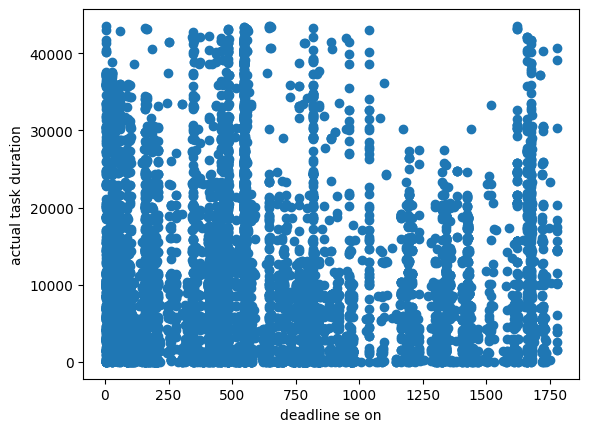

In [ ]:
# How actual task duration changes when deadline set on changes in the data without outliers
plt.scatter(final_df['deadline_set_on'], final_df['actual task duration in minutes'])
plt.xlabel('deadline se on')
plt.ylabel('actual task duration')
plt.show()

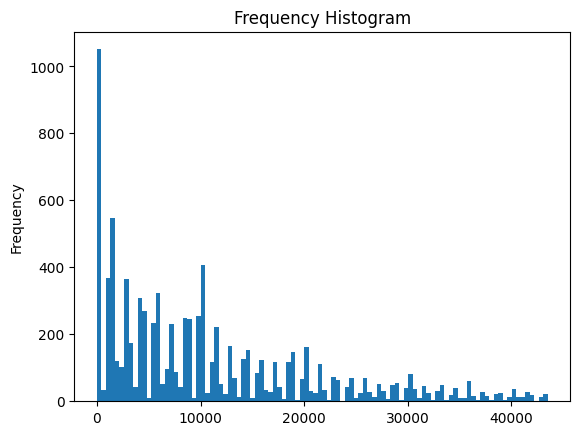

In [ ]:
# Distribution of 'actual task duration in minutes' values after removing outliers
plt.hist(final_df['actual task duration in minutes'], bins=100)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

Regression on filtered data

In [ ]:
X2 = final_df[['action_id', 'from_status_id', 'deadline_set_on']]
Y2 = final_df['actual task duration in minutes']

In [ ]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size=0.25, random_state=42)

In [ ]:
forest2 = RandomForestRegressor()
forest2.fit(x_train2, y_train2)

RandomForestRegressor()

In [ ]:
mean_squared_error(y_test2, forest2.predict(x_test2), squared=False)

8235.171140605751

In [ ]:
r2_score(y_test2, forest2.predict(x_test2))

0.4031234008546709

In [ ]:
boost2 = GradientBoostingRegressor()
boost2.fit(x_train2, y_train2)

GradientBoostingRegressor()

In [ ]:
mean_squared_error(y_test2, boost2.predict(x_test2), squared=False)

8643.1586503913

In [ ]:
r2_score(y_test2, boost2.predict(x_test2))

0.3425173995670091

As we see random forest regressor performs better on filtered data, so we will use it, and will try to search good hyperparameters to improve the results.

Trying to search random combinations of values described below

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 15)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [50, 189, 328, 467, 607, 746, 885, 1025, 1164, 1303, 1442, 1582, 1721, 1860, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
forest3 = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = forest3, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
rf_random.fit(x_train2, y_train2)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 189, 328, 467, 607,
                                                         746, 885, 1025, 1164,
                                                         1303, 1442, 1582, 1721,
                                                         1860, 2000]},
                   random_state=42, verbose=2)

In [ ]:
rf_random.best_params_

{'n_estimators': 746,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 110,
 'bootstrap': True}

In [ ]:
best_random = rf_random.best_estimator_

In [ ]:
mean_squared_error(y_test2, best_random.predict(x_test2), squared=False)

8152.23521733741

In [ ]:
r2_score(y_test2, best_random.predict(x_test2))

0.41508508144313705

In [ ]:
filename = "final best_random_model.pickle"
pickle.dump(best_random, open(filename, "wb"))

In [ ]:
# loaded_model = pickle.load(open(filename, "rb"))

Trying to search all possible combinations of hyperparameter values close to best random model's values.

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [100, 110, 120],
    'max_features': ['auto'],
    'min_samples_leaf': [3, 4, 5, 10],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [735, 746, 757]
}
forest4 = RandomForestRegressor()
grid_search = GridSearchCV(estimator = forest4, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(x_train2, y_train2)
grid_search.best_params_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 746}

In [ ]:
best_grid = grid_search.best_estimator_

In [ ]:
mean_squared_error(y_test2, best_grid.predict(x_test2), squared=False)

8158.492375283459

In [ ]:
r2_score(y_test2, best_grid.predict(x_test2))

0.4141868469117215

In [ ]:
filename2 = "final best_grid_model.pickle"
pickle.dump(best_grid, open(filename2, "wb"))

In [ ]:
# loaded_model2 = pickle.load(open(filename2, "rb"))

In [181]:
# Checking if our model is overfitting.
mean_squared_error(y_train2, best_grid.predict(x_train2), squared=False)

7450.136300006005

In [182]:
r2_score(y_train2, best_grid.predict(x_train2))

0.47373806433435095

As we can see evaluation results on traininmg data give better results, it is probably, because id numbers are random, and there is some pattern just by chance, which our model finds.